<a href="https://colab.research.google.com/github/ssrinivas-berkeley/genai-playground/blob/main/Origami_Coach_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧻 Origami Coach — Fold Guidance (Colab, fixed)

Use webcam or upload a photo of a sheet of paper.
The notebook detects the largest paper contour, checks alignment/straightness, and overlays hints.


## 🛠️ Setup

In [1]:

!pip -q install --upgrade opencv-python-headless==4.10.0.84 Pillow==10.4.0 numpy==2.0.2
import cv2, numpy as np, io, base64, os
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from google.colab import files, output
os.makedirs("results", exist_ok=True)
print("✅ Installed.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 122.3 MB/s eta 0:00:00
✅ Installed.


## 📷 Capture from webcam (or skip)

In [5]:

js = '''
async function capture() {
  const stream = await navigator.mediaDevices.getUserMedia({video:true});
  const video = document.createElement('video');
  video.srcObject = stream; await video.play();
  await new Promise(r=>setTimeout(r, 600));
  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth; canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  stream.getTracks().forEach(t => t.stop());
  const b64 = canvas.toDataURL('image/png');
  return b64;
}
''';
display(Javascript(js))
print("Run the next cell to capture frame.")

<IPython.core.display.Javascript object>

Run the next cell to capture frame.


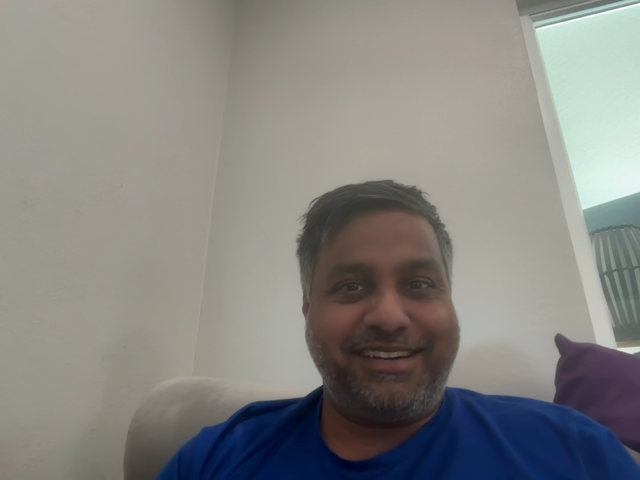

In [15]:

from google.colab import output

b64 = output.eval_js(r"""
(async () => {
  const stream = await navigator.mediaDevices.getUserMedia({ video: true });
  const video = document.createElement('video');
  video.srcObject = stream; await video.play();
  await new Promise(r => setTimeout(r, 600));   // give it a moment
  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth; canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  stream.getTracks().forEach(t => t.stop());
  return canvas.toDataURL('image/png');
})()
""")
img_path = None
if b64 and b64.startswith("data:image"):
    header, data = b64.split(',',1)
    img = Image.open(io.BytesIO(base64.b64decode(data))).convert("RGB")
    img.save("results/capture.png"); img_path = "results/capture.png"
    display(img)
else:
    print("No webcam frame captured.")


## 📁 Or upload an image

In [10]:

uploaded = files.upload()
for k in uploaded:
    img_path = k
    break
if not img_path:
    raise SystemExit("No image provided.")
print("Using:", img_path)


Using: results/capture.png


## 🧠 Analyze fold alignment

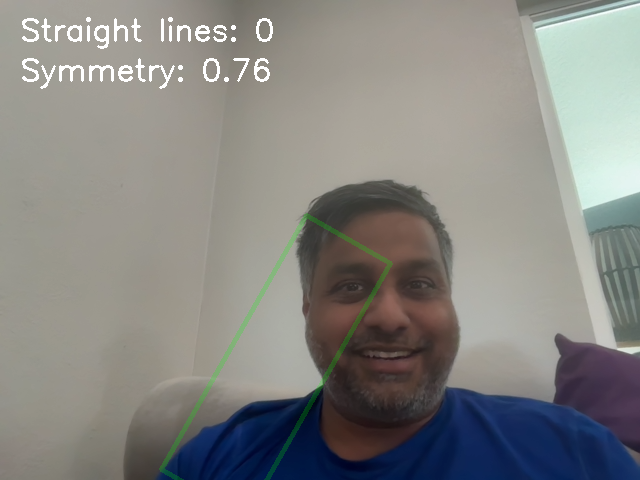

Hints:
 Crease more firmly — edges not straight.
Rotate or align paper — it's tilted.


In [16]:

import numpy as np, cv2, os
from PIL import Image

def analyze_fold(path):
    img = cv2.imread(path)
    if img is None:
        # Fallback reading via PIL
        im = Image.open(path).convert("RGB")
        img = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
    orig = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, "No contours found."
    c = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect).astype(int)

    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=150)
    straightness = 0
    if lines is not None:
        for rho, theta in lines[:,0,:]:
            deg = np.degrees(theta) % 180
            if min(abs(deg-0), abs(deg-90)) < 10:
                straightness += 1

    h, w = gray.shape
    left = gray[:, :w//2]
    right = np.fliplr(gray[:, w//2:])
    sym = (np.corrcoef(left.flatten(), right.flatten())[0,1] + 1)/2

    tips = []
    if straightness < 5: tips.append("Crease more firmly — edges not straight.")
    angle = rect[2]
    if abs(angle) > 10: tips.append("Rotate or align paper — it's tilted.")
    if sym < 0.7: tips.append("Fold halves evenly — alignment off.")
    if not tips: tips = ["Looks good! Proceed to the next fold."]

    overlay = orig.copy()
    cv2.drawContours(overlay, [box], 0, (0,255,0), 3)
    out = cv2.addWeighted(orig, 0.8, overlay, 0.2, 0)
    cv2.putText(out, f"Straight lines: {straightness}", (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(out, f"Symmetry: {sym:.2f}", (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    out_path = "results/analysis.png"
    cv2.imwrite(out_path, out)
    return out_path, "\n".join(tips)

out_img, tips = analyze_fold(img_path)
from IPython.display import Image as IPyImage, display
display(IPyImage(filename=out_img))
print("Hints:\n", tips)
